Libraries

In [72]:
# External Libraries
import numpy as np
import pandas as pd
from math import ceil, pi, sin
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score

Load backend for fake noise

In [65]:
runtime_service = QiskitRuntimeService(
    token = 'RyY3IAqFaCATY4Ipapkww91nwsWmW1AJgjJpXY3aNWlD',
    channel= 'ibm_cloud',
    instance= 'crn:v1:bluemix:public:quantum-computing:eu-de:a/2c7afd2718fe41cf912e8ad6e77f57c7:8c3584e4-f5c6-4940-be8b-82166457b586::',
)

backend_name = "ibm_aachen"
ibm_backend = runtime_service.backend(backend_name)

qiskit_runtime_service._discover_account:WARNING:2025-10-13 00:37:42,716: Loading account with the given token. A saved account will not be used.


Dataset
 - load dataset
 - keep only most important features, based on the calculations in file Feature_selection.ipynb

In [14]:
dataset_save = "Dataset/Toxicity-13F.csv"
dataset_only_rev_features = "Dataset/Toxicity-Top5.csv"
    
df = pd.read_csv(dataset_save)
print(df['Class'].value_counts())
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)
print(df['Class'].value_counts())
#df.head()

df5 = pd.read_csv(dataset_only_rev_features)
print(df5['Class'].value_counts())
df5.head()



Class
NonToxic    115
Toxic        56
Name: count, dtype: int64
Class
1    115
0     56
Name: count, dtype: int64
Class
1    115
0     56
Name: count, dtype: int64


,MDEC-23,SpMin1_Bhs,GATS8s,CrippenMR,SpMax5_Bhv,Class
0,60.1757,2.3109,1.0575,0.0000,3.5545,1
1,44.5031,2.1117,1.7013,172.2000,3.6066,1
2,37.5488,2.0198,0.7828,173.4028,3.6441,1
3,40.5929,2.0191,1.0298,177.2726,3.6564,1
4,52.7343,2.1664,0.7427,171.1315,3.5216,1


Global parameters

In [119]:
N_QUBITS = df5.shape[1] - 1  # N_QUBITS = number of features
TAU = 30e-9              # 30 ns (seconds)
A0 = 2 * pi * 15e9       # rad/s
B0 = 2 * pi * 11e9       # rad/s
#REPS = 4
#M = 4
REPS = 64
M = ceil(2000 / REPS)    # -> 32 slices when REPS=64
DELTA_T = TAU / M
ORDER = 2                # Suzuki-Trotter order
RANDOM_STATE = 42
N_SPLITS = 5

# added by Jiri
OPTIMIZATION_LEVEL = 0
SHOTS = 1024
NOISE_MODEL = None

Metrics directly (classically)

In [33]:
def run_experiment_classical(X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    metrics = { 
        'auc': [], 
        'f1': [], 
        'bal_acc': [], 
        'prec_0': [], 
        'rec_0': [], 
        'prec_1': [], 
        'rec_1': [] 
    }

    fold_idx = 0
    for train_idx, test_idx in skf.split(X, y):
        fold_idx += 1
        Xtrain, Xtest = X[train_idx], X[test_idx]
        ytrain, ytest = y[train_idx], y[test_idx]

        # Preprocessing
        imputer = SimpleImputer(strategy='median')
        imputer.fit(Xtrain)
        Xtrain_im = imputer.transform(Xtrain)
        Xtest_im = imputer.transform(Xtest)

        scaler = StandardScaler()
        scaler.fit(Xtrain_im)
        Xtrain_std = scaler.transform(Xtrain_im)
        Xtest_std = scaler.transform(Xtest_im)

        # Classifier
        clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
        clf.fit(Xtrain_std, ytrain)
        ypred = clf.predict(Xtest_std)
        yproba = clf.predict_proba(Xtest_std)[:, 1]

        # Metrics
        metrics['auc'].append(roc_auc_score(ytest, yproba))
        metrics['f1'].append(f1_score(ytest, ypred, zero_division=0))
        metrics['bal_acc'].append(balanced_accuracy_score(ytest, ypred))
        metrics['prec_0'].append(precision_score(ytest, ypred, pos_label=0, zero_division=0))
        metrics['rec_0'].append(recall_score(ytest, ypred, pos_label=0, zero_division=0))
        metrics['prec_1'].append(precision_score(ytest, ypred, pos_label=1, zero_division=0))
        metrics['rec_1'].append(recall_score(ytest, ypred, pos_label=1, zero_division=0))

    # Print median metrics
    print("\n=== Median metrics over 5 folds (classical only) ===")
    for k, v in metrics.items():
        print(f"{k:8s}: {np.median(v):.4f}")

    return metrics

In [51]:
if __name__ == "__main__":
    print("Whole dataset:")
    X = df.drop(columns=['Class']).values
    y = df['Class'].values

    metrics_classical = run_experiment_classical(X, y)

    print("\n")
    print("Top 5 relevant features:")
    X5 = df5.drop(columns=['Class']).values
    y5 = df5['Class'].values
    metrics_classical_top5 = run_experiment_classical(X5, y5)

Whole dataset:

=== Median metrics over 5 folds (classical only) ===
auc     : 0.7075
f1      : 0.8085
bal_acc : 0.6601
prec_0  : 0.6000
rec_0   : 0.4167
prec_1  : 0.7586
rec_1   : 0.8261


Top 5 relevant features:

=== Median metrics over 5 folds (classical only) ===
auc     : 0.6364
f1      : 0.7755
bal_acc : 0.5949
prec_0  : 0.5000
rec_0   : 0.3636
prec_1  : 0.7308
rec_1   : 0.8261


QFMs

- Helper functions

In [115]:
# -------------------------
# Helper building functions for Hamiltonians
# -------------------------

def print_circuit_specs(circuit):
    print(
        f"""
    Quantum circuit {circuit.name} specifications
    -----------------------------

                    Depth: {circuit.depth()}
                Gate count: {len(circuit)}
        Nonlocal gate count: {circuit.num_nonlocal_gates()}
            Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
    """
    )

def plot_metrics_bar(metrics_1, metrics_2):
    # Compute mean of each metric
    metric_names = list(metrics_1.keys())

    metric_values_1 = [np.mean(metrics_1[m]) for m in metric_names]
    metric_values_2 = [np.mean(metrics_2[m]) for m in metric_names]

    # plot
    x = np.arange(len(metric_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(6, 3))
    bars1 = ax.bar(x - width/2, metric_values_1, width, label='Classical only', color='blue')
    bars2 = ax.bar(x + width/2, metric_values_2, width, label='Quantum_only', color='orange')
    ax.set_ylabel('Mean Value')
    ax.set_title('Comparison of Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def s_of_t(t, tau=TAU):
    # s(t) = sin^2( (pi/2) * sin^2(pi t / (2 tau)) )
    inner = sin(pi * t / (2 * tau)) ** 2
    return sin((pi / 2) * inner) ** 2

def A_of_t(t): 
    return A0 * (1.0 - s_of_t(t))

def B_of_t(t): 
    return B0 * s_of_t(t)

def build_HD(n):
    #H_D = - sum_i X_i represented as a SparsePauliOp
    labels = []
    coeffs = []
    for i in range(n):
        s = ['I'] * n
        s[i] = 'X'
        labels.append(''.join(s))
        coeffs.append(-1.0)
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def build_HP_from_sample(x_std, Jij):
    # Problem Hamiltonian HP(x) = sum_i hi Z_i + sum_{i<j} Jij Z_i Z_j
    # where hi = x_i and Jij is correlation matrix entries.
    n = len(x_std)
    labels = []
    coeffs = []
    # local fields
    for i in range(n):
        s = ['I'] * n
        s[i] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(x_std[i]))
    # pairwise ZZ
    for i, j in combinations(range(n), 2):
        s = ['I'] * n
        s[i] = 'Z'
        s[j] = 'Z'
        labels.append(''.join(s))
        coeffs.append(float(Jij[i, j]))
    pauli_list = [Pauli(label) for label in labels]
    return SparsePauliOp(pauli_list, coeffs)

def make_evolution_circuit(n_qubits, HP_op_time_dep_fn):
    qc = QuantumCircuit(n_qubits)
    # initial |+>^{n}
    for q in range(n_qubits):
        qc.h(q)

    # Prebuild H_D (Pauli sum op)
    HD_op = build_HD(n_qubits)

    # Append m slices. For slice k (0..m-1) freeze at midpoint t_{k+1/2} = (k+0.5)*dt
    for k in range(M):
        t_mid = (k + 0.5) * DELTA_T
        A = A_of_t(t_mid)
        B = B_of_t(t_mid)
        HP_mid = HP_op_time_dep_fn(k)

        # H_slice = A * HD + B * HP_mid
        H_slice = (A * HD_op) + (B * HP_mid)

        evo_gate = PauliEvolutionGate(H_slice, time=DELTA_T, synthesis=SuzukiTrotter(order=ORDER, reps=REPS))
        qc.append(evo_gate, qc.qubits)

    return qc

def build_circuit_for_sample(x_std, Jij):
    n = len(x_std)
    HP_op = build_HP_from_sample(x_std, Jij)
    qc = make_evolution_circuit(n, lambda k: HP_op)
    return qc

def combine_features(X_classical, X_quantum, gamma_q=1.0, apply_scaling=True):
    if apply_scaling:
        qs = StandardScaler()
        Xq_scaled = qs.fit_transform(X_quantum)
    else:
        Xq_scaled = X_quantum.copy()

    Xq_scaled *= float(gamma_q)
    X_combined = np.hstack([X_classical, Xq_scaled])
    return X_combined, qs

- Feature extraction

In [112]:
def run_quantum_feature_extraction(X_std, Jij, n_qubits=N_QUBITS, shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL):
    n_samples = X_std.shape[0]
    features = np.zeros((n_samples, n_qubits), dtype=float)

    if noise_model is None:
        simulator = AerSimulator(method="statevector", shots=shots)
    else:
        simulator = AerSimulator(method="statevector", shots=shots, noise_model=noise_model)
    estimator = EstimatorV2(mode=simulator)
    pass_manager = generate_preset_pass_manager(backend=simulator, optimization_level=optimization_level)

    # Prebuild single-qubit Z observables (SparsePauliOp) for expectation readout
    z_observables = []
    for i in range(n_qubits): 
        s = ['I'] * n_qubits 
        s[i] = 'Z' 
        z_observables.append(SparsePauliOp([Pauli(''.join(s))], [1.0]))

    with tqdm(total=n_samples, desc="Aer features", unit="sample", dynamic_ncols=True) as pbar:
        for idx in range(n_samples):
            qc = build_circuit_for_sample(X_std[idx], Jij)
            qc_transpiled = pass_manager.run(qc)

            # Estimate <Z_i> for each qubit i
            job = estimator.run([(qc_transpiled, z_observables)])
            pub_result = job.result()[0]
            features[idx, :] = pub_result.data.evs
            
            pbar.update(1)

    return features

- Run experiment

In [116]:
def _make_meta():
    return {
    "REPS": REPS,
    "M": M,
    "ORDER": ORDER,
    "DELTA_T": DELTA_T,
    "A0": A0,
    "B0": B0,
    "TAU": TAU,
    "RANDOM_STATE": RANDOM_STATE
    }

def run_experiment(X, y, outdir):
    outdir = Path(f"saved_models/{outdir}")
    outdir.mkdir(parents=True, exist_ok=True)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    metrics = { 'auc': [], 'f1': [], 'bal_acc': [], 'prec_0': [], 'rec_0': [], 'prec_1': [], 'rec_1': [] }

    fold_idx = 0 
    for train_idx, test_idx in skf.split(X, y): 
        fold_idx += 1 
        Xtrain, Xtest = X[train_idx], X[test_idx] 
        ytrain, ytest = y[train_idx], y[test_idx]
     
        # preprocessing 
        imputer = SimpleImputer(strategy='median') 
        imputer.fit(Xtrain) 
        Xtrain_im = imputer.transform(Xtrain) 
        Xtest_im = imputer.transform(Xtest) 

        scaler = StandardScaler() 
        scaler.fit(Xtrain_im) 
        Xtrain_std = scaler.transform(Xtrain_im) 
        Xtest_std = scaler.transform(Xtest_im) 

        # Jij computed from training set Pearson correlations, diag set to 0 
        rho = np.corrcoef(Xtrain_std, rowvar=False) 
        np.fill_diagonal(rho, 0.0) 
        Jij = rho.copy() 

        # Quantum features for all training and test samples 
        print(f"Fold {fold_idx}: computing quantum features for {len(Xtrain_std)} train + {len(Xtest_std)} test samples...") 
        Xtilde_train = run_quantum_feature_extraction(Xtrain_std, Jij, n_qubits=N_QUBITS,shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL)
        Xtilde_test = run_quantum_feature_extraction(Xtest_std, Jij, n_qubits=N_QUBITS,shots=SHOTS, optimization_level=OPTIMIZATION_LEVEL, noise_model=NOISE_MODEL)

        gamma_q = 1.0   # tune this (grid-search) if desired
        Xaug_train, q_scaler = combine_features(Xtrain_std, Xtilde_train, gamma_q=gamma_q, apply_scaling=True)
        # IMPORTANT: transform test quantum features with same scaler
        Xq_test_scaled = q_scaler.transform(Xtilde_test) * gamma_q
        Xaug_test = np.hstack([Xtest_std, Xq_test_scaled])
        
        # Augment classical features with quantum features (gamma_q = 1) 
        #Xaug_train = np.hstack([Xtrain_std, Xtilde_train]) 
        #Xaug_test = np.hstack([Xtest_std, Xtilde_test]) 
        
        # classifier 
        clf = GradientBoostingClassifier(random_state=RANDOM_STATE) 
        clf.fit(Xaug_train, ytrain) 
        ypred = clf.predict(Xaug_test) 
        yproba = clf.predict_proba(Xaug_test)[:, 1] 
        
        # metrics 
        metrics['auc'].append(roc_auc_score(ytest, yproba)) 
        metrics['f1'].append(f1_score(ytest, ypred, zero_division=0)) 
        metrics['bal_acc'].append(balanced_accuracy_score(ytest, ypred)) 
        metrics['prec_0'].append(precision_score(ytest, ypred, pos_label=0, zero_division=0)) 
        metrics['rec_0'].append(recall_score(ytest, ypred, pos_label=0, zero_division=0)) 
        metrics['prec_1'].append(precision_score(ytest, ypred, pos_label=1, zero_division=0)) 
        metrics['rec_1'].append(recall_score(ytest, ypred, pos_label=1, zero_division=0)) 

    metrics_mean = { k: np.mean(v) for k, v in metrics.items() }

    # Save artifacts
    model_path = outdir / "model.joblib"
    imputer_path = outdir / "imputer.joblib"
    scaler_path = outdir / "scaler.joblib"
    Jij_path = outdir / "Jij.npy"
    meta_path = outdir / "meta.json"
    metrics_path = outdir / "metrics.json"

    joblib.dump(clf, model_path)
    joblib.dump(imputer, imputer_path)
    joblib.dump(scaler, scaler_path)
    np.save(Jij_path, Jij)
    with open(meta_path, "w") as fh:
        json.dump(_make_meta(), fh, indent=2)
    with open(metrics_path, "w") as fh:
        json.dump(metrics_mean, fh, indent=2)

    return metrics_mean



Train model and get metrics

In [ ]:
if __name__ == "__main__":
    X = df5.drop(columns=['Class']).values
    y = df5['Class'].values
    #NOISE_MODEL = None
    #metrics_quantum_top5 = run_experiment(X,y, outdir="quantum_top5_noiseless")

    NOISE_MODEL = NoiseModel.from_backend(ibm_backend)
    metrics_quantum_top5_noise = run_experiment(X,y, outdir="quantum_top5_noise")

Fold 1: computing quantum features for 136 train + 35 test samples...


Aer features:   0%|          | 0/136 [00:00<?, ?sample/s]

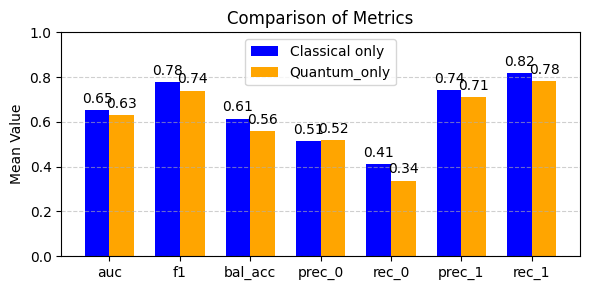

In [118]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_noiseless/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)

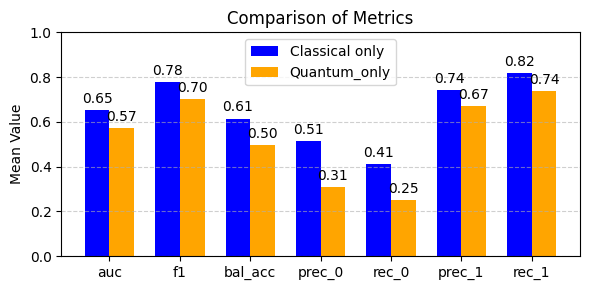

In [121]:
metrics_quantum_top5 = json.load(open("saved_models/quantum_top5_noiseless/metrics.json"))
plot_metrics_bar(metrics_classical_top5, metrics_quantum_top5)